In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import random
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [2]:
with open('../data/USPTO_50K_PtoR_aug20/val/src-val.txt', 'r') as f:
    products = f.read().splitlines()

with open('../data/USPTO_50K_PtoR_aug20/val/tgt-val.txt', 'r') as f:
    reactants = f.read().splitlines()

In [4]:
products[:5]

['O = C ( N c 1 c c c ( O c 2 c c n c 3 [nH] c c c 2 3 ) c ( F ) c 1 ) C ( F ) ( F ) F',
 'c 1 c c 2 c ( O c 3 c c c ( N C ( = O ) C ( F ) ( F ) F ) c c 3 F ) c c n c 2 [nH] 1',
 'c 1 ( N C ( = O ) C ( F ) ( F ) F ) c c c ( O c 2 c c n c 3 [nH] c c c 2 3 ) c ( F ) c 1',
 'c 1 c c ( O c 2 c c n c 3 [nH] c c c 2 3 ) c ( F ) c c 1 N C ( = O ) C ( F ) ( F ) F',
 'F c 1 c c ( N C ( = O ) C ( F ) ( F ) F ) c c c 1 O c 1 c c n c 2 [nH] c c c 1 2']

In [8]:
reactants[:5]

['O = C ( O C ( = O ) C ( F ) ( F ) F ) C ( F ) ( F ) F . N c 1 c c c ( O c 2 c c n c 3 [nH] c c c 2 3 ) c ( F ) c 1',
 'c 1 c c 2 c ( O c 3 c c c ( N ) c c 3 F ) c c n c 2 [nH] 1 . C ( = O ) ( O C ( = O ) C ( F ) ( F ) F ) C ( F ) ( F ) F',
 'c 1 ( N ) c c c ( O c 2 c c n c 3 [nH] c c c 2 3 ) c ( F ) c 1 . C ( = O ) ( O C ( = O ) C ( F ) ( F ) F ) C ( F ) ( F ) F',
 'c 1 c c ( O c 2 c c n c 3 [nH] c c c 2 3 ) c ( F ) c c 1 N . C ( = O ) ( O C ( = O ) C ( F ) ( F ) F ) C ( F ) ( F ) F',
 'F c 1 c c ( N ) c c c 1 O c 1 c c n c 2 [nH] c c c 1 2 . C ( = O ) ( O C ( = O ) C ( F ) ( F ) F ) C ( F ) ( F ) F']

In [2]:
data_dir='../data/uspto50'
df = pd.read_pickle(f'{data_dir}/final_data.pickle')

In [3]:
df['set'].unique()

array(['train', 'valid', 'test'], dtype=object)

In [4]:
df.head()

,reactants_mol,products_mol,reaction_type,set,num_reacts,num_prods,ratio,reactant_token,reactant_bfs_id,reactant_bfs_depth,reactant_dfs_id,reactant_dfs_depth,product_token,product_bfs_id,product_bfs_depth,product_dfs_id,product_dfs_depth
0,"[CS(=O)(=O)OC[C@H]1CCC(=O)O1, Fc1ccc(Nc2ncnc3c...",[O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl...,<RX_1>,train,2,1,1.121951,"[[F, c, 1, c, c, c, (, N, c, 2, n, c, n, c, 3,...","[[0, 1, 1, 2, 32, 3, 3, 31, 33, 33, 4, 5, 6, 7...","[[0, 1, 1, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 8, 8,...","[[0, 1, 1, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 10, 1...","[[0, 1, 1, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 8, 8,...","[[O, =, C, 1, C, C, [C@H], (, C, N, 2, C, C, N...","[[0, 0, 1, 1, 2, 40, 3, 3, 4, 5, 5, 6, 7, 39, ...","[[0, 0, 1, 1, 2, 3, 3, 3, 4, 5, 5, 6, 7, 8, 8,...","[[0, 0, 1, 1, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 9,...","[[0, 0, 1, 1, 2, 3, 3, 3, 5, 6, 6, 7, 8, 9, 9,..."
1,[COC(=O)c1cc(CCCc2cc3c(=O)[nH]c(N)nc3[nH]2)cs1],[Nc1nc2[nH]c(CCCc3csc(C(=O)O)c3)cc2c(=O)[nH]1],<RX_6>,train,1,1,1.045455,"[[C, O, C, (, =, O, ), c, 1, c, c, (, C, C, C,...","[[0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 22, 22, 6, 21,...","[[0, 1, 2, 2, 2, 3, 3, 3, 3, 4, 5, 5, 6, 7, 8,...","[[0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 7, 8, 9,...","[[0, 1, 2, 2, 2, 3, 3, 3, 3, 4, 5, 5, 6, 7, 8,...","[[N, c, 1, n, c, 2, [nH], c, (, C, C, C, c, 3,...","[[0, 1, 1, 2, 21, 21, 3, 19, 19, 4, 18, 20, 5,...","[[0, 1, 1, 2, 3, 3, 4, 5, 5, 6, 7, 8, 9, 9, 10...","[[0, 1, 1, 2, 3, 3, 4, 5, 5, 6, 7, 8, 9, 9, 10...","[[0, 1, 1, 2, 3, 3, 4, 5, 5, 6, 7, 8, 9, 9, 10..."
2,"[CC1(C)OB(B2OC(C)(C)C(C)(C)O2)OC1(C)C, FC(F)(F...",[CC1(C)OB(c2cccc(Nc3nccc(C(F)(F)F)n3)c2)OC1(C)C],<RX_9>,train,2,1,1.384615,"[[C, C, 1, (, C, ), O, B, (, B, 2, O, C, (, C,...","[[0, 1, 1, 1, 2, 2, 3, 15, 15, 4, 4, 14, 16, 1...","[[0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 7,...","[[0, 1, 1, 1, 2, 2, 3, 4, 4, 5, 5, 6, 7, 7, 8,...","[[0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 7,...","[[C, C, 1, (, C, ), O, B, (, c, 2, c, c, c, c,...","[[0, 1, 1, 1, 2, 2, 3, 23, 23, 4, 4, 22, 24, 2...","[[0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 7, 6,...","[[0, 1, 1, 1, 2, 2, 3, 4, 4, 5, 5, 6, 7, 8, 9,...","[[0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 7, 6,..."
3,[CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)OCc1ccccc1],[CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)O],<RX_6>,train,1,1,1.318182,"[[C, C, (, C, ), (, C, ), O, C, (, =, O, ), N,...","[[0, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 5, 6, 6, 7,...","[[0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4,...","[[0, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 5, 6, 6, 7,...","[[0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4,...","[[C, C, (, C, ), (, C, ), O, C, (, =, O, ), N,...","[[0, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 5, 6, 6, 7,...","[[0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4,...","[[0, 1, 1, 2, 2, 2, 3, 3, 4, 5, 5, 5, 6, 6, 7,...","[[0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4,..."
4,"[Fc1cc2c(Cl)ncnc2cn1, NC1CCCCCC1]",[Fc1cc2c(NC3CCCCCC3)ncnc2cn1],<RX_1>,train,2,1,1.052632,"[[F, c, 1, c, c, 2, c, (, Cl, ), n, c, n, c, 2...","[[0, 1, 1, 2, 11, 11, 3, 3, 10, 10, 4, 9, 5, 6...","[[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 5, 4, 4,...","[[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 9, 9,...","[[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 5, 4, 4,...","[[F, c, 1, c, c, 2, c, (, N, C, 3, C, C, C, C,...","[[0, 1, 1, 2, 18, 18, 3, 3, 17, 4, 4, 16, 5, 1...","[[0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 6, 7, 8, 9, 9,...","[[0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 6, 7, 8, 9, 10...","[[0, 1, 1, 2, 3, 3, 4, 4, 5, 6, 6, 7, 8, 9, 9,..."


In [5]:
reactant_token = df['reactant_token'].to_list()
num_reactans = [len(r) for r in reactant_token]
reactant_token = [sub_entry for entry in reactant_token for sub_entry in entry]

In [6]:
len(reactant_token)

85538

In [7]:
product_token = df['product_token'].to_list()
product_token  = [sub_entry for i, entry in enumerate(product_token) for sub_entry in entry for _ in range(num_reactans[i])]

In [8]:
len(product_token)

85538

In [9]:
product_bfs_pos = df['product_bfs_depth'].to_list()

In [10]:
len([sub_entry for i, entry in enumerate(product_bfs_pos) for sub_entry in entry for _ in range(num_reactans[i])])

85538

In [11]:
from uspto_ifn import USPTO50

In [12]:
uspto = USPTO50(data_dir='../data/uspto50', split='valid', to_gen=-1)

In [34]:
len(uspto)

234494

In [13]:
dataloader = DataLoader(uspto, batch_size=5, collate_fn=uspto.collate_fn)

In [14]:
dp = next(iter(dataloader))

In [15]:
len(dp)

8

In [16]:
reactants, products, mask, reactant_bfs_pos, reactant_dfs_pos, product_bfs_pos, product_dfs_pos, mol_id = dp
print(reactants.size())
print(products.size())
print(mask.size())
print(reactant_bfs_pos.size())
print(reactant_dfs_pos.size())
print(product_bfs_pos.size())
print(product_dfs_pos.size())
print(mol_id.size())

torch.Size([5, 39])
torch.Size([5, 55])
torch.Size([5, 55])
torch.Size([5, 39])
torch.Size([5, 39])
torch.Size([5, 55])
torch.Size([5, 55])
torch.Size([5, 1])


In [31]:
reactants[0, 1:]

tensor([ 0,  4, 10,  7, 10, 10, 10, 10,  2,  0,  2,  3,  4,  5,  4,  5, 10,  7,
        89, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,
        99, 99])

In [30]:
reactant_bfs_pos[0, 1:]

tensor([ 1,  2,  3,  3,  4,  5,  6,  5,  5,  6,  6,  6,  7,  7,  7,  7,  4,  4,
        92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92,
        92, 92])

In [29]:
reactant_dfs_pos[0, 1:]

tensor([ 1,  2,  3,  3,  4,  5,  6,  5,  5,  6,  6,  6,  9,  9,  9,  9,  4,  4,
        92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92,
        92, 92])

In [33]:
print([uspto.token_decoder[i] for i in reactants[0]][1:])

['C', 'O', 'c', '1', 'c', 'c', 'c', 'c', '(', 'C', '(', '=', 'O', ')', 'O', ')', 'c', '1', '<eor>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


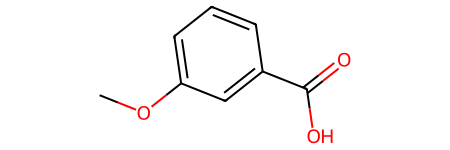

In [28]:
mol = Chem.MolFromSmiles('COc1cccc(C(=O)O)c1')
mol